<a href="https://colab.research.google.com/github/surajsrivathsa/ovgu_deeplearning/blob/master/Assignment_1_Let_the_Tensors_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning programming task

**Assignment 1:** Let the Tensors Flow

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Aditya Dey : 230580 : aditya.dey@st.ovgu.de
3. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de


There are 5 types of experiments that are run to check the effect of changing various hyper parameters on the fincal outcome(test predictions). Please find the list of experiments, experiments are present at last part of notebook.

1. run_experiments() - function to run general and random experiments.
2. run_hidden_layers_experiment() - function to run experiments on various configs of hidden layers
3. run_initalization_experiment() - function to run experiments on different weight/bias initializations
4. run_learningrate_experiment() - function to run experiment on learning rate
5. run_iterations_experiment() - fnction to run experiment on iterations
6. run_batch_size_experiment() - function to experiment on different batch sizes


In [0]:
import os
%tensorflow_version 2.x
import tensorflow as tf
from sklearn import preprocessing
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import copy
import numpy as np

In [0]:
files.upload()

Saving datasets.py to datasets.py


{'datasets.py': b'import numpy as np\n\n\nclass MNISTDataset:\n    """\'Bare minimum\' class to wrap MNIST numpy arrays into a dataset."""\n    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,\n                 to01=True, shuffle=True, seed=None):\n        """\n        Use seed optionally to always get the same shuffling (-> reproducible\n        results).\n        """\n        self.batch_size = batch_size\n        self.train_data = train_imgs\n        self.train_labels = train_lbs.astype(np.int32)\n        self.test_data = test_imgs\n        self.test_labels = test_lbls.astype(np.int32)\n\n        if to01:\n            # int in [0, 255] -> float in [0, 1]\n            self.train_data = self.train_data.astype(np.float32) / 255\n            self.test_data = self.test_data.astype(np.float32) / 255\n\n        self.size = self.train_data.shape[0]\n\n        if seed:\n            np.random.seed(seed)\n        if shuffle:\n            self.shuffle_train()\n        

In [0]:
print(os.getcwd())

/content


In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

path = '.'
 
files = os.listdir(path)
for name in files:
    print(name)

.config
datasets.py
sample_data


In [0]:
from datasets import MNISTDataset


11493376/11490434 [==============================] - 0s 0us/step


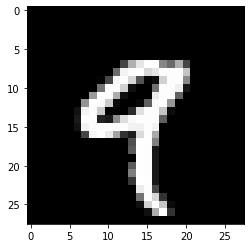

In [0]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.imshow(train_images[4], cmap="Greys_r")

In [0]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

In [0]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


**Below is the model for single linear model copied from Jens Johanmeister blog**

In [0]:
training_steps = 10000
learning_rate = 0.05
W1 = tf.Variable(initial_value=np.random.rand(784, 10), dtype= tf.float32)
B1 = tf.Variable(initial_value=np.random.rand(1, 10), dtype = tf.float32)

Error Faced during training in next step due to data type issue in weights and biases
Weights and biases were of float64(double type) but float32(float) type expected.

Error message: InvalidArgumentError: cannot compute MatMul as input #0(zero-based) was expected to be a float tensor but is a double tensor [Op:MatMul]
Solution link : https://stackoverflow.com/questions/54255431/invalidargumenterror-cannot-compute-matmul-as-input-0zero-based-was-expected

In [0]:
print(W1.shape)
print(B1.shape)
#print(B1)
#print(W1)

(784, 10)
(1, 10)


In [0]:
for step in range(training_steps):
  img_batch, lbl_batch = data.next_batch()
  with tf.GradientTape() as tape:
    logits = tf.matmul(img_batch, W1) + B1
    error = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = lbl_batch, logits = logits))
  
  grads1 = tape.gradient(error, [W1, B1])
  W1.assign_sub(learning_rate * grads1[0])
  B1.assign_sub(learning_rate * grads1[1])

  if(step % 100 == 0):
    preds = tf.argmax(logits, axis = 1, output_type = tf.int32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
    print("Loss: {} and Accuracy: {}".format(error, accuracy))

In [0]:
test_preds = tf.argmax(tf.matmul(data.test_data, W1) + B1, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.913, shape=(), dtype=float32)


**Single layer Perceptron is completed, moving on to MLP**

**init_params function could dynamically generate parameters for number of hidden layers. It can also tune the initialization according to some value of param_initializer**

In [0]:
def init_params(layer_matrix=[784,100,10], param_initializer=0.0):
  params = {}
  params_list = []
  param_idx = len(layer_matrix)
  if (len(layer_matrix) < 2):
    raise Exception("layer matrix must have atleast an input and output layer")

  for i in range(1, param_idx):
    l1 = layer_matrix[i-1]
    l2 = layer_matrix[i]
    params["W" + str(i)] = tf.Variable(initial_value=np.random.randn(l1, l2) * param_initializer, dtype= tf.float32)
    params["B" + str(i)] = tf.Variable(initial_value=np.random.uniform(1, 12) * param_initializer, dtype = tf.float32)
    #params_list.append("W" + str(i))
    #params_list.append("B" + str(i))
    params_list.append(params["W" + str(i)] )
    params_list.append(params["B" + str(i)])
  return [params, params_list];

"""
params, params_list = init_params()
for key,val in params.items():
  print(key + ": " + str(val.shape))
params_list
"""

'\nparams, params_list = init_params()\nfor key,val in params.items():\n  print(key + ": " + str(val.shape))\nparams_list\n'

**init_hyperparameters generates required hyper parameters**

In [0]:
def init_hyperparameters(iterations=100,learning_rate=0.1,batch_size=128):
  hyper_parameters = {}
  hyper_parameters["iterations"] = iterations
  hyper_parameters["learning_rate"] = learning_rate
  hyper_parameters["batch_size"] = batch_size
  return hyper_parameters;

"""
hyper_parameters = init_hyperparameters()
for key, val in hyper_parameters.items():
  print(key + " : " + str(val))
"""

'\nhyper_parameters = init_hyperparameters()\nfor key, val in hyper_parameters.items():\n  print(key + " : " + str(val))\n'

**init_activations create a inital dictionary to keep track of activations which could come in handy later**

In [0]:
def init_activations(layer_matrix=[784,100,10]):
  activations = {}
  for i in range(1, len(layer_matrix)):
    activations["Z" + str(i)] = None
    activations["A" + str(i)] = None
  
  return activations;

"""
activations = init_activations()
for key, val in activations.items():
  print(key + " : " + str(val))
"""

'\nactivations = init_activations()\nfor key, val in activations.items():\n  print(key + " : " + str(val))\n'

**Loss function calculates Softmax cross entropy loss and returns the scalar tensor having cost**

In [0]:
def calculate_loss(actual_labels, predicted_labels):
  # please remeber to send logits which is unnormalized output before applying softmax as below function has some internal implemenation to convert
  # this into softmax first then calculate the loss. If softmax predicted output is provided then this causes calculation mistake in the below tensorflow function
  xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = actual_labels, logits = predicted_labels))
  return xent

**Function that takes in one batch of features and labels along with parameters and implements one pass of forward propagation. This also calls the above loss function and records the forward propagation onto gradient tape which is extremely important during back propagation to get the gradients**

In [0]:
def forward_propagation(params, hyper_parameters, activations, features, labels, activation_function="relu"):
  learning_rate = hyper_parameters["learning_rate"]
  logits = None

  #record the forward propagation on to tape, call the tape in backward propagation so that it can replay these tasks and calculate grads
  # 
  with tf.GradientTape() as tape:
    num = (len(list(activations.keys())) // 2) + 1
    for i in range(1, num):
      #special case for first input layer as the input is features and not activations
      # if else statement to handle special layers(first and last) and also control activations to be applied to the layer
      if( i == 1):
        activations["Z" + str(i)] = tf.matmul(features, params["W" + str(i)]) + params["B" + str(i)]

        if(activation_function == "relu"):
          activations["A" + str(i)] = tf.nn.relu(activations["Z" + str(i)])
        elif(activation_function == "tanh"):
          activations["A" + str(i)] = tf.nn.tanh(activations["Z" + str(i)])
        else:
          activations["A" + str(i)] = tf.nn.sigmoid(activations["Z" + str(i)])
      # For hidden layer
      elif(i > 1 and i < num-1):
        activations["Z" + str(i)] = tf.matmul(activations["A" + str(i-1)], params["W" + str(i)]) + params["B" + str(i)]

        if(activation_function == "relu"):
          activations["A" + str(i)] = tf.nn.relu(activations["Z" + str(i)])
        elif(activation_function == "tanh"):
          activations["A" + str(i)] = tf.nn.tanh(activations["Z" + str(i)])
        else:
          activations["A" + str(i)] = tf.nn.sigmoid(activations["Z" + str(i)])

      #special case to handle last layer as it contains some other activation function
      # output layer is hardcoded to softmax, it could also be passed from parameters in future
      elif(i == num - 1):
        activations["Z" + str(i)] = tf.matmul(activations["A" + str(i-1)], params["W" + str(i)]) + params["B" + str(i)]
        logits = activations["Z" + str(i)] 
        activations["A" + str(i)] = tf.nn.softmax(activations["Z" + str(i)])

    # importtant to calculate the cost with the gradient tape with clause scope, if this is done outside With clause then loss wont be recordsed and we wont get the gradient later
    cost = calculate_loss(labels, logits)
  return [tape, logits, activations, cost];
"""
errors recieved in this function:
1. reason: tf.gradienttape did not have closing braces 
error: AttributeError: __enter__   
solution: https://stackoverflow.com/questions/51427729/python-error-attributeerror-enter

2. reason: missed to do floor division in num = (len(list(activations.keys())) / 2) + 1
error: TypeError: 'float' object cannot be interpreted as an integer

"""
  

"\nerrors recieved in this function:\n1. reason: tf.gradienttape did not have closing braces \nerror: AttributeError: __enter__   \nsolution: https://stackoverflow.com/questions/51427729/python-error-attributeerror-enter\n\n2. reason: missed to do floor division in num = (len(list(activations.keys())) / 2) + 1\nerror: TypeError: 'float' object cannot be interpreted as an integer\n\n"

**Function that takes the tape from forward propagation that has recorded variables of one batch and calculates gradients and updates the network params**

In [0]:
def backward_propagation(tape, params, cost, params_list, hyper_parameters):
  learning_rate = hyper_parameters["learning_rate"]

  # Calculate the gradient by replaying the tape and providing the list of variables for which we need the gradient ie; [W1, B1, W2, B2] in params_list
  grads = tape.gradient(cost, params_list)
  #print(type(grads[1]))
  #print(len(grads))

  # Update network parameters. Use assign_suband not minus sign directly - as they are tracked tensorflow variables
  for i in range(1, len(grads), 2):
    ix = i//2 + 1
    #print(type(params["W" + str(ix)]))
    params["W" + str(ix)].assign_sub(learning_rate * grads[i-1])
    params["B" + str(ix)].assign_sub(learning_rate * grads[i])
  
  return params

"""
1. reason: tape requires list of actual tensorflow variables to keep track of, i had provided it a list of strings like "W1" instead of contents inside W1
error: TypeError: Cannot convert value 'W1' to a TensorFlow DType.
fix: fixed in init_param function

2. reason: tape requires a valid cost and list of parameters it should update, I had provided an invalid cost. Hence tape provided list of objects
of all NoneType
error: TypeError: unsupported operand type(s) for *: 'float' and 'NoneType' : params["W" + str(ix)].assign_sub(learning_rate * grads[i-1])
fix: added cost as parameter to function and used the same inside tape

3. reason: again recieved similar error as 2
error: TypeError: unsupported operand type(s) for *: 'float' and 'NoneType' : params["W" + str(ix)].assign_sub(learning_rate * grads[i-1])
fix: introspection forward propagation function told that the calculation of cost was not inside the scope of With clause of gradienttape
hence tape was not tracking cost, even though cost was computed outside with clause. Hence tape could not replay the cost resulting in no gradients
"""


'\n1. reason: tape requires list of actual tensorflow variables to keep track of, i had provided it a list of strings like "W1" instead of contents inside W1\nerror: TypeError: Cannot convert value \'W1\' to a TensorFlow DType.\nfix: fixed in init_param function\n\n2. reason: tape requires a valid cost and list of parameters it should update, I had provided an invalid cost. Hence tape provided list of objects\nof all NoneType\nerror: TypeError: unsupported operand type(s) for *: \'float\' and \'NoneType\' : params["W" + str(ix)].assign_sub(learning_rate * grads[i-1])\nfix: added cost as parameter to function and used the same inside tape\n\n3. reason: again recieved similar error as 2\nerror: TypeError: unsupported operand type(s) for *: \'float\' and \'NoneType\' : params["W" + str(ix)].assign_sub(learning_rate * grads[i-1])\nfix: introspection forward propagation function told that the calculation of cost was not inside the scope of With clause of gradienttape\nhence tape was not tra

**This function is the main function which obtains data and labels by batch, Computes forward and backward propagation. It does this over and over again until some iteration count/step is reached. Meanwhle intermideate values such as training error, cost, iteration number are recorded into dictiionary report_dict which is used later to write plots**

In [0]:
def run_model(hyper_parameters, params, activations,  params_list, activation_function="relu"):
  iterations = hyper_parameters["iterations"];
  report_dict = {}
  costs = []
  steps = []
  accuracy = []
  for step in range(iterations+1):

    # Get the batch of features and labels
    features,  labels = data.next_batch()
    #print(features.shape)
    #print(labels.shape)

    # Compute Forward propagation over this batch
    tape, logits, activations, cost = forward_propagation(params, hyper_parameters, activations, features, labels, activation_function);
    
    # Compute backward propagation over this batch and update network parameters
    params = backward_propagation(tape, params, cost, params_list, hyper_parameters)

    # After every 100 steps record the network training error, cost and return these back
    if(step % 100 == 0):
      preds = tf.argmax(logits, axis=1, output_type=tf.int32)
      acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
      steps.append(step)
      accuracy.append(acc)
      costs.append(cost)
      
      if(step %1000 == 0):
        print("")
        print("Cost at {} iteration and accuracy are: {} , {}".format(step, cost, acc))

  report_dict["cost"] = costs
  report_dict["steps"] = steps
  report_dict["accuracy"] = accuracy
  return costs, report_dict

"""
1. reason: missed using cost parameter while calling backward prop
error: TypeError: backward_propagation() missing 1 required positional argument: 'hyper_parameters'
fix: added parameter

2. reason: using an old global variable instead of variable passed to function
error: shape mismatch while calculating cost function
fix: replaced the old global var "train_feature_batch" with local var called "feature"
"""

'\n1. reason: missed using cost parameter while calling backward prop\nerror: TypeError: backward_propagation() missing 1 required positional argument: \'hyper_parameters\'\nfix: added parameter\n\n2. reason: using an old global variable instead of variable passed to function\nerror: shape mismatch while calculating cost function\nfix: replaced the old global var "train_feature_batch" with local var called "feature"\n'

In [0]:
# performing Initializations of hyperparameters, parameters and activations for test run
# Run this if only doing single experiment else use the run_experiment() function below
layer_matrix = [784, 200, 50 ,10]
hyper_parameters = init_hyperparameters(iterations = 5000, learning_rate = 0.1, batch_size = 128)
params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
activations = init_activations(layer_matrix= layer_matrix)
print(type(params_list[0]))

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


In [0]:
# complete model run, Run this for only Single experiment run, For bunch of experiments run the run_experiments function below
costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")


Cost at 0 iteration and accuracy are: 2.3023881912231445 , 0.09375

Cost at 1000 iteration and accuracy are: 0.4984578490257263 , 0.875

Cost at 2000 iteration and accuracy are: 0.1317758411169052 , 0.9453125

Cost at 3000 iteration and accuracy are: 0.09090478718280792 , 0.984375

Cost at 4000 iteration and accuracy are: 0.042099352926015854 , 0.9921875


**Function to get training accuracy of the model after minibatch training**

In [0]:
def get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu"):
  features = data.train_data;
  labels = data.train_labels

  #During testing we just need to forward propagate and get final results, dont have to worry about loss and back propagation
  train_tape, train_logits, train_activations, train_cost = forward_propagation(params, hyper_parameters, activations, features, labels, activation_function)

  # we are converting softmax probability distribtuion to hardmax for example [0.2, 0.4, 0.3, 0.1] => [0, 1, 0, 0] 1 is substituted for max element to mke it to one hot encoded vector
  train_preds = tf.argmax(train_logits, axis=1,output_type=tf.int32)
  acc = tf.reduce_mean(tf.cast(tf.equal(train_preds, labels),tf.float32))
  print("Accuracy of Train set: " + str(acc.numpy()))
  return train_preds

**Function to test the model with test data and test lables and report accuracy, the predicted results are returned**

In [0]:
# function to get accuracy on test dataset

def test_model(hyper_parameters, params, activations,  params_list, activation_function="relu"):
  features = data.test_data;
  labels = data.test_labels

  #During testing we just need to forward propagate and get final results, dont have to worry about loss and back propagation
  test_tape, test_logits, test_activations, test_cost = forward_propagation(params, hyper_parameters, activations, features, labels, activation_function)

  # we are converting softmax probability distribtuion to hardmax for example [0.2, 0.4, 0.3, 0.1] => [0, 1, 0, 0] 1 is substituted for max element to mke it to one hot encoded vector
  test_preds = tf.argmax(test_logits, axis=1,output_type=tf.int32)
  acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, labels),tf.float32))
  print("Accuracy of Test set: " + str(acc.numpy()))
  return test_preds

In [0]:
predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
print(predicted_labels.shape)
print(data.test_labels.shape)

Accuracy of Test set: 0.9747
(10000,)
(10000,)


**Draw plots of collected information during model run such as accuracy and loss vs iteration steps using pandas plotting library**

In [0]:
def plot_figures(hyper_parameters, report_dict):

  # First copy the dictionary so that original dict remains unchanged
  dict = copy.deepcopy(report_dict)

  # the report_dict has cost and accuracy values as tensorflow scalar, We need to convert it to actual number for us to be able to
  # plot it, hence iterate oover the dict and convert tf objects to number type
  for key, val in dict.items():
    if(key == "cost" or key == "accuracy"):
      for i in range(0, len(val)):
          val[i] = val[i].numpy()

  report_df =  pd.DataFrame(dict, columns=['cost', 'steps', 'accuracy'])
  report_df.head()
  
  # gca stands for 'get current axis'
  ax = plt.gca()
  report_df.plot(kind='line',x='steps',y='cost',ax=ax, title = "Cost vs Iterations")
  plt.show()

  ax1 = plt.gca()
  report_df.plot(kind='line',x='steps',y='accuracy', color='red', ax=ax1, title = "Accuracy vs Iterations")
  plt.show()

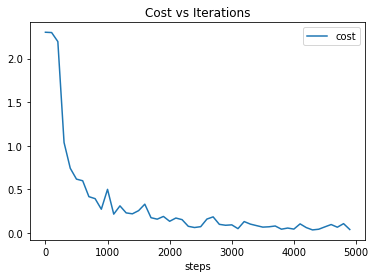

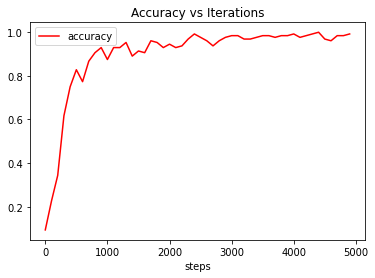

In [0]:
plot_figures(hyper_parameters, report_dict)

**Below function just analyzes 3-4 missclassified images. We can clearly see that**

In [0]:
def print_mislabeled_images(test_images, features, actual_labels, predicted_labels, classes=[0,1,2,3,4,5,6,7,8,9]):

    # Collect missclassified indiceswhich can be used to filter test data for only the data which has been mis classified later  
    misclassified_indices = np.asarray(np.where(actual_labels != predicted_labels))
    
    print(features.shape)
    print(features[8,].shape)
    print(predicted_labels.shape)
    
    f = plt.figure()
    num_images = len(misclassified_indices[0])
    lst = misclassified_indices[0]
    print("Missclassified image count: " + str(num_images) + " , considering 4 images for analysis")

    # Just print 4 missclassified images
    for i in range(4):
        print("index: " + str(lst[i]))
        print("Actual label: " + str(actual_labels[lst[i]]))
        print("Predicted label: " + str(predicted_labels[lst[i]].numpy()))
        f.add_subplot(1, 4, i + 1)
        
        plt.imshow(X = test_images[lst[i]], cmap="Greys_r", aspect = "auto",interpolation="nearest")
        
"""
reference: https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images
"""

'\nreference: https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images\n'

(10000, 784)
(784,)
(10000,)
Missclassified image count: 281 , considering 4 images for analysis
index: 149
Actual label: 2
Predicted label: 3
index: 151
Actual label: 9
Predicted label: 8
index: 247
Actual label: 4
Predicted label: 6
index: 259
Actual label: 6
Predicted label: 0


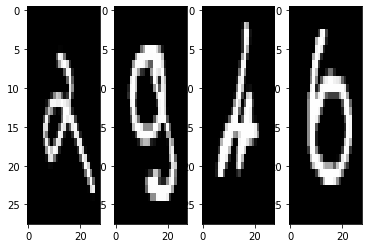

In [0]:
# Run this as part of single expermient and not group. Use run_experiment function for other purposes
print_mislabeled_images(test_images, data.test_data, data.test_labels, predicted_labels,[0,1,2,3,4,5,6,7,8,9])

**As we can clearly see that the 6 looks like 0, 4 looks like 6 due to loop, 9 is labeled as 8 as the lower tip of 9 is curling towards itself and looking like 8. 2 is labeled as 3 as its interpreted as 3**

**Below function is an important function as it can run a series of experiments using above mentioned run_model, foreard_prop, back_prop function. We almost always need to run this functionn for group takss. Thhis function currently consists of 10 experiments. More can be added later. At each experiment a note is printed and loss,accuracy scores are plotted**

In [0]:
def run_experiments():

  # exp1: basic parameters without tuning
  print("Experiment1: basic parameters without tuning")
  layer_matrix = [784, 100,10]
  hyper_parameters = init_hyperparameters(iterations = 7000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 1)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment1 completed ==============")
  print("")

  # exp2: weights and bias initialization tuned by multiplying them with 0.01
  print("Experiment 2: weights and bias initialization tuned by multiplying them with 0.01")
  layer_matrix = [784, 100,10]
  hyper_parameters = init_hyperparameters(iterations = 7000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)
  print("================ Experiment 2 completed ==============")
  print("")

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)

  
  # exp3: learning rate tripled to 0.3
  print("Experiment 3: learning rate increased by 5 times to 0.5")
  layer_matrix = [784, 100,10]
  hyper_parameters = init_hyperparameters(iterations = 7000, learning_rate = 0.5, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment 3 completed ==============")
  print("")

  # exp4: Added three hidden layer and decreased iterations
  print("Experiment 4A: Added three hidden layer and decreased iterations to 5000 to prevent plausible overfit")
  layer_matrix = [784, 200, 70, 30 ,10]
  hyper_parameters = init_hyperparameters(iterations = 5000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)

  print("================ Experiment 4A completed ==============")
  print("")

  print("Experiment 4B: Added three hidden layer and increased iterations to 10000")
  layer_matrix = [784, 200, 70, 30 ,10]
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)

  print("================ Experiment 4B completed ==============")
  print("")

  # exp5: Added two hidden layer and kept iterations at 5000
  print("Experiment 5: Added two hidden layer and kept iterations at 5000")
  layer_matrix = [784, 200, 50 ,10]
  hyper_parameters = init_hyperparameters(iterations = 5000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)

  print("================ Experiment 5 completed ==============")
  print("")

  # exp6: Using sigmoid activation
  print("Experiment 6: Using sigmoid activation")
  layer_matrix = [784, 200, 70, 30 ,10]
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="sigmoid")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="sigmoid")
  plot_figures(hyper_parameters, report_dict)

  print("================ Experiment 6 completed ==============")
  print("")

  # exp7: Using tanh activation
  print("Experiment 7: Using tanh activation")
  layer_matrix = [784, 200, 70, 30 ,10]
  hyper_parameters = init_hyperparameters(iterations = 5000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="tanh")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="tanh")
  plot_figures(hyper_parameters, report_dict)

  print("================ Experiment 7 completed ==============")
  print("")
  
  #Extreme cases
  # exp8: weights and bias initialized to zero
  print("Experiment 8: All weights and bias initialzed to zero")
  layer_matrix = [784, 200, 70, 30 ,10]
  hyper_parameters = init_hyperparameters(iterations = 5000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.0)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)

  print("================ Experiment 8 completed ==============")
  print("")

  # exp9: increasing iterations to 12000
  print("Experiment 9: Increasing training iterations to check for plausible overfit")
  layer_matrix = [784, 200, 70, 30 ,10]
  hyper_parameters = init_hyperparameters(iterations = 15000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)

  print("================ Experiment 9 completed ==============")
  print("")
  



Experiment1: basic parameters without tuning

Cost at 0 iteration and accuracy are: 181.22512817382812 , 0.1640625

Cost at 1000 iteration and accuracy are: 0.7619893550872803 , 0.8203125

Cost at 2000 iteration and accuracy are: 0.8018203973770142 , 0.7578125

Cost at 3000 iteration and accuracy are: 0.3725939393043518 , 0.859375

Cost at 4000 iteration and accuracy are: 0.2640761733055115 , 0.9375

Cost at 5000 iteration and accuracy are: 0.30460357666015625 , 0.8984375

Cost at 6000 iteration and accuracy are: 0.29699501395225525 , 0.9140625
Accuracy of Test set: 0.9044


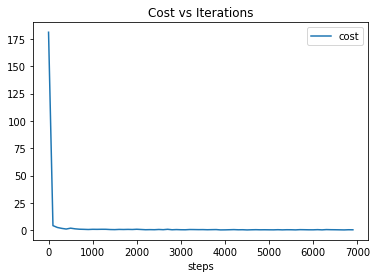

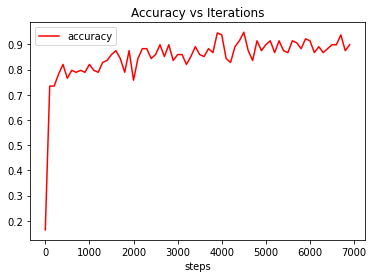

================ Experiment1 completed ==============

Experiment 2: weights and bias initialization tuned by multiplying them with 0.01
================ Experiment 2 completed ==============


Cost at 0 iteration and accuracy are: 2.3016815185546875 , 0.078125

Cost at 1000 iteration and accuracy are: 0.33105117082595825 , 0.8984375

Cost at 2000 iteration and accuracy are: 0.14193972945213318 , 0.96875

Cost at 3000 iteration and accuracy are: 0.24644127488136292 , 0.9453125

Cost at 4000 iteration and accuracy are: 0.17749781906604767 , 0.9453125

Cost at 5000 iteration and accuracy are: 0.19486017525196075 , 0.9453125

Cost at 6000 iteration and accuracy are: 0.09009150415658951 , 0.9765625
Accuracy of Test set: 0.9708


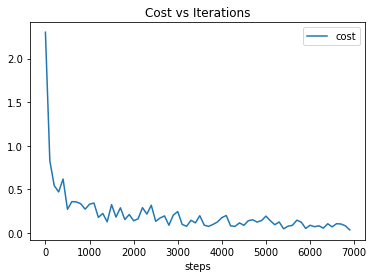

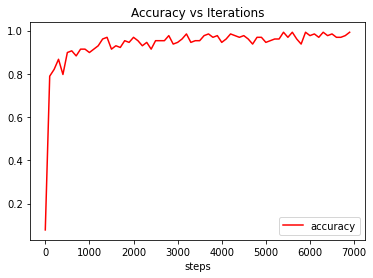

Experiment 3: learning rate increased by 5 times to 0.5

Cost at 0 iteration and accuracy are: 2.301064968109131 , 0.1484375

Cost at 1000 iteration and accuracy are: 0.136001318693161 , 0.9375

Cost at 2000 iteration and accuracy are: 0.07957687228918076 , 0.9765625

Cost at 3000 iteration and accuracy are: 0.0421585738658905 , 0.984375

Cost at 4000 iteration and accuracy are: 0.0233159102499485 , 0.9921875

Cost at 5000 iteration and accuracy are: 0.030076926574110985 , 0.984375

Cost at 6000 iteration and accuracy are: 0.008743355982005596 , 1.0
Accuracy of Test set: 0.9793


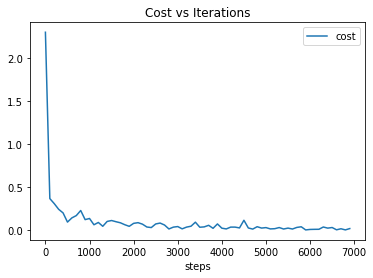

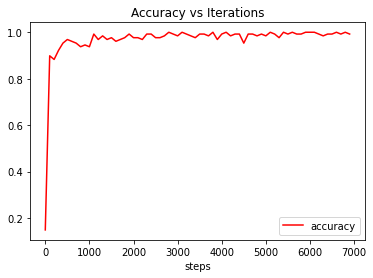

================ Experiment 3 completed ==============

Experiment 4A: Added three hidden layer and decreased iterations to 5000 to prevent plausible overfit

Cost at 0 iteration and accuracy are: 2.302603244781494 , 0.09375

Cost at 1000 iteration and accuracy are: 2.2913949489593506 , 0.1015625

Cost at 2000 iteration and accuracy are: 0.4108926057815552 , 0.8984375

Cost at 3000 iteration and accuracy are: 0.12373603880405426 , 0.9765625

Cost at 4000 iteration and accuracy are: 0.13080984354019165 , 0.953125
Accuracy of Test set: 0.9684


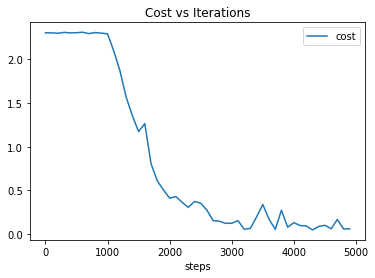

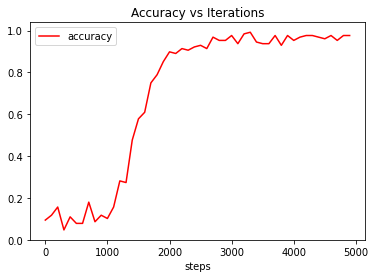

================ Experiment 4A completed ==============

Experiment 4B: Added three hidden layer and increased iterations to 10000

Cost at 0 iteration and accuracy are: 2.302281618118286 , 0.1171875

Cost at 1000 iteration and accuracy are: 2.2942147254943848 , 0.109375

Cost at 2000 iteration and accuracy are: 0.39290010929107666 , 0.890625

Cost at 3000 iteration and accuracy are: 0.2625572085380554 , 0.953125

Cost at 4000 iteration and accuracy are: 0.14213673770427704 , 0.9765625

Cost at 5000 iteration and accuracy are: 0.07354769855737686 , 0.96875

Cost at 6000 iteration and accuracy are: 0.01604931615293026 , 1.0

Cost at 7000 iteration and accuracy are: 0.02093181014060974 , 1.0

Cost at 8000 iteration and accuracy are: 0.01650943048298359 , 0.9921875

Cost at 9000 iteration and accuracy are: 0.010375509038567543 , 1.0
Accuracy of Test set: 0.9726


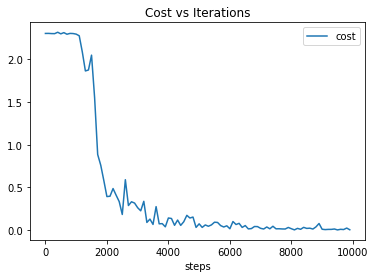

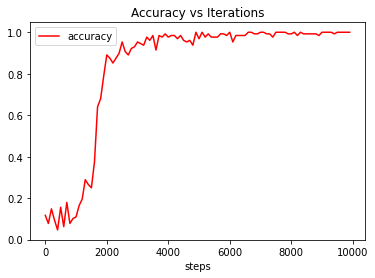

================ Experiment 4B completed ==============

Experiment 5: Added two hidden layer and kept iterations at 5000

Cost at 0 iteration and accuracy are: 2.3028342723846436 , 0.0703125

Cost at 1000 iteration and accuracy are: 0.3795544505119324 , 0.9296875

Cost at 2000 iteration and accuracy are: 0.13262686133384705 , 0.96875

Cost at 3000 iteration and accuracy are: 0.09098485112190247 , 0.96875

Cost at 4000 iteration and accuracy are: 0.11632665991783142 , 0.9453125
Accuracy of Test set: 0.9727


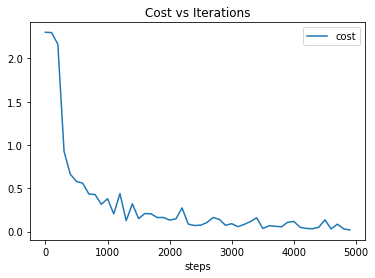

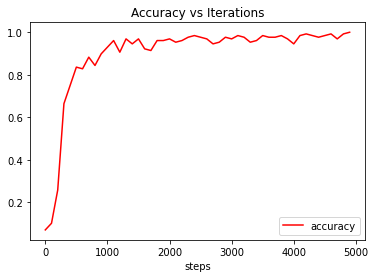

================ Experiment 5 completed ==============

Experiment 6: Using sigmoid activation

Cost at 0 iteration and accuracy are: 2.3030009269714355 , 0.078125

Cost at 1000 iteration and accuracy are: 2.298553466796875 , 0.0703125

Cost at 2000 iteration and accuracy are: 2.2952606678009033 , 0.15625

Cost at 3000 iteration and accuracy are: 2.3032705783843994 , 0.1015625

Cost at 4000 iteration and accuracy are: 2.3033509254455566 , 0.125

Cost at 5000 iteration and accuracy are: 2.3002524375915527 , 0.109375

Cost at 6000 iteration and accuracy are: 2.2970571517944336 , 0.1328125

Cost at 7000 iteration and accuracy are: 2.309579372406006 , 0.078125

Cost at 8000 iteration and accuracy are: 2.302337169647217 , 0.09375

Cost at 9000 iteration and accuracy are: 2.3101346492767334 , 0.09375
Accuracy of Test set: 0.1135


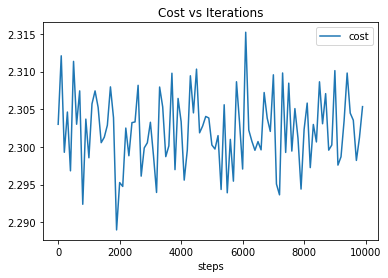

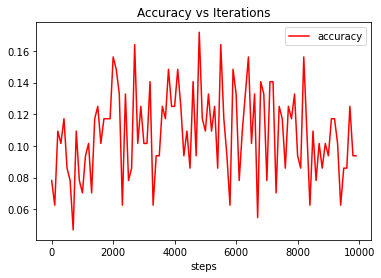

================ Experiment 6 completed ==============

Experiment 7: Using tanh activation

Cost at 0 iteration and accuracy are: 2.302711248397827 , 0.1328125

Cost at 1000 iteration and accuracy are: 2.294063091278076 , 0.09375

Cost at 2000 iteration and accuracy are: 0.6224597692489624 , 0.8203125

Cost at 3000 iteration and accuracy are: 0.34403860569000244 , 0.90625

Cost at 4000 iteration and accuracy are: 0.28830450773239136 , 0.9375
Accuracy of Test set: 0.9523


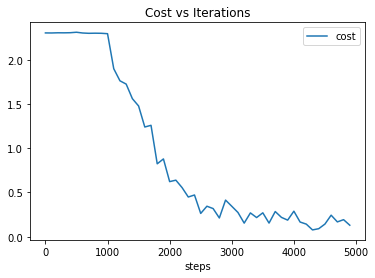

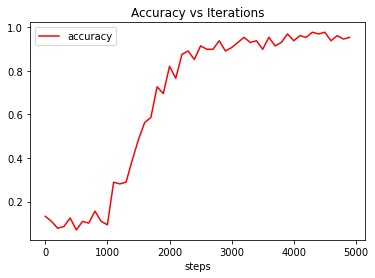

================ Experiment 7 completed ==============

Experiment 8: All weights and bias initialzed to zero

Cost at 0 iteration and accuracy are: 2.3025853633880615 , 0.0859375

Cost at 1000 iteration and accuracy are: 2.3025853633880615 , 0.1015625

Cost at 2000 iteration and accuracy are: 2.3025853633880615 , 0.09375

Cost at 3000 iteration and accuracy are: 2.3025853633880615 , 0.0859375

Cost at 4000 iteration and accuracy are: 2.3025853633880615 , 0.0859375
Accuracy of Test set: 0.098


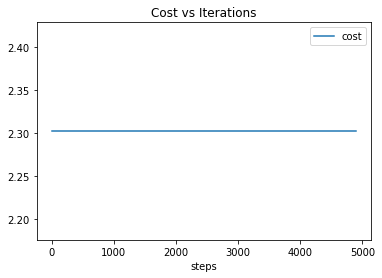

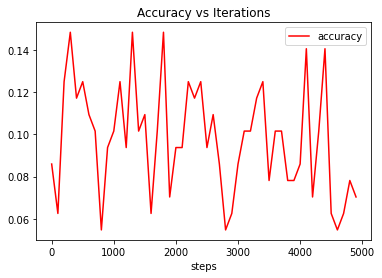

================ Experiment 8 completed ==============

Experiment 9: Increasing training iterations to check for plausible overfit

Cost at 0 iteration and accuracy are: 2.3023812770843506 , 0.109375

Cost at 1000 iteration and accuracy are: 2.2943804264068604 , 0.140625

Cost at 2000 iteration and accuracy are: 0.40834686160087585 , 0.890625

Cost at 3000 iteration and accuracy are: 0.10082394629716873 , 0.984375

Cost at 4000 iteration and accuracy are: 0.12535473704338074 , 0.96875

Cost at 5000 iteration and accuracy are: 0.04316595941781998 , 0.984375

Cost at 6000 iteration and accuracy are: 0.02863463945686817 , 0.9921875

Cost at 7000 iteration and accuracy are: 0.04614279419183731 , 0.9765625

Cost at 8000 iteration and accuracy are: 0.017934564501047134 , 0.9921875

Cost at 9000 iteration and accuracy are: 0.009542127139866352 , 1.0

Cost at 10000 iteration and accuracy are: 0.0031095920130610466 , 1.0

Cost at 11000 iteration and accuracy are: 0.0030767004936933517 , 1.0

C

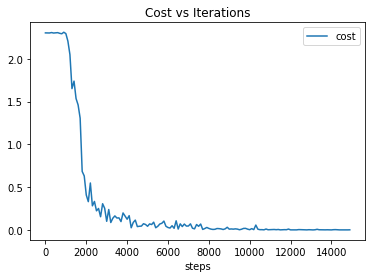

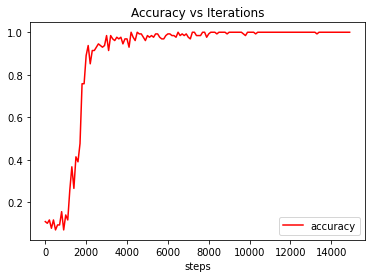

================ Experiment 9 completed ==============



In [0]:
#Ruuning experiments with various changes and getting the respective output and plots
run_experiments()

Comparisions of the Experiments

Exp 1: Basic NN with one hidden layer and relu activation provides the hint that maybe more hidden layers or iteration is the way forward as it is evident that the loss decreases without much oscillations due to relu

Exp 2: We can improve the network from Exp1 by changing their weight initiualizations. In exp1 we were choosing random normalized values between 0,1. In exp2 we further reduce this and take this close to zero by multiplying weights and biases by 0.01. This has a profound effect on the outcome as we can see network trains faster and does reasonably well on test set with 97.08 % accuracy

Exp 3: Why not change the learning rate? We checked with different learning rates and stuck with learning rate of 0.5 which is five times the earlier rate. Surprisingly, the loss decreased and provided one of the highest test accuracy scores of 97.9, albeit it seems like there were some oscillations while trying to reach minima and a slight overfit is evident by looking at train set metrics

Exp 4A: Network now contains three hidden layers instead of one, but with less training iterations of 5000, As assumed there seems to be slight underfit in the model as train error < test error. Maybe more training is required.

Exp 4B: Now training steps are increased to 10000, we see that now underfit is gone and network is able to acheive around 99.9% train accuracy and 97.25 test accuracy

Exp 5: Decrease network configuration to two hidden layers with iteration = 5000, as expected there is again slight underfit with train error around 96% and test error around 97%. Also comparing Exp4A and this one we can clearly see that loss of three layered network decreases more slowly and needs more training, whilst network with less hidden layers can decreases their losses with pace

Exp 6: Using Sigmoid we can clearly see that our training is going nowhere even until 10000 steps, the gradients seems to be infitesimal as most of the activations are falling at the corners making the learning slower. Hence Sigmoid may not be first choice activation function in hidden layer

Exp 7: Using tanh we can clearly see the demarcation between networks that used relu , sigmoid and tanh. Tanh is some where in between relu and sigmoid in its ability to help network learn at pace. The losses are decreasing slower than relu

Exp 8: All weights and bias is initialized to zero. It seems like whenever all of the network weights/biases are initialized to zero or any constant, network is not able to learn. One possible explaination could be that all the neurons start with same value as they have zero and they recieve same grads to update. This causes neurons to not learn anythn new. The first neuron in the output layer kowns the same thing as all the other neurons in the network. Hence it is better to start with miniscule random values as parameters

Exp 9: This is the same three layered network but ran with 15000 steps during training. As expected the loss keeps on decreasing and is coming closer to zero, training accuracy touches 100%, but test accuracy remains 97.5%, hinting that this model could be used as one of final model with appropriate learning rate

**Experiments to check cost and accuracy plot by changing only number of hidden layers and hidden layers configuration and keeping other hyperparameters constant**


**From above genral experiments it seems like Relu is the clear winner when it comes to activation function, but other parameters need much more experiments to decide its values**

Reference - https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

Some of the concepts mentioned in this thread would be experimented upon in the below function.

We will experiment for alpha = 2(38 neurons) and alpha = 5(15 neurons) and also for other configurations such as 150, 200, and 70 neurons.(experiments - 1,2,3,4,5)

There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:

 

1.   The number of hidden neurons should be between the size of the input layer the size of the output layer. and
2.   The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer. ==> 784 * 0.67 = 525 neurons (experiment - 6)
3.   The number of hidden neurons should be less than twice the size of the input layer. ==> already satisfied with existing config, but we will check what happens if this staement is not followed (experiment - 7)

We will also experiment on hidden layers of 1, 2 and 3 and above mentioned thumb rules

In [0]:
def run_hidden_layers_experiments():

  # exp1: alpha = 2 -- 38 neuron
  print("Experiment1: For alpha = 2 -- 38 neuron")
  layer_matrix = [784, 38,10]
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 1)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment1 completed ==============")
  print("")

  # exp2: alpha = 2 -- 15 neuron
  print("Experiment 2: For alpha = 5 -- 15 neuron")
  layer_matrix = [784, 15, 10]
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)
  
  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment 2 completed ==============")
  print("")

  # exp3: 70 neurons 1 hidden layer
  print("Experiment 3: 70 neurons 1 hidden layer")
  layer_matrix = [784, 70, 10]
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)
  
  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment 3 completed ==============")
  print("")


  # exp4: 150 neurons - 2 hidden layer"
  print("Experiment 4: 150 neurons - 2 hidden layer")
  layer_matrix = [784, 100, 50, 10]
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)
  
  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment 4 completed ==============")
  print("")

  # exp5: 200 neurons - 3 hidden layer
  print("Experiment 5: 200 neurons - 3 hidden layer")
  layer_matrix = [784, 110, 60, 30, 10]
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)
  
  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment 5 completed ==============")
  print("")

  # exp6: num of neurons = 2/3 hidden layer => 525 neurons ==> [350, 150, 90, 35]
  print("Experiment 6: num of neurons = 2/3 hidden layer => 525 neurons ==> [784, 350, 150, 90, 35, 10]")
  layer_matrix = [784, 350, 150, 90, 35, 10]
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)
  
  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment 6 completed ==============")
  print("")

  # exp7: check what happens if we break thumb rule of num of hidden units < 2 * num of input units ==> hidden units = 1600
  print("Experiment 7: check what happens if we break thumb rule of num of hidden units < 2 * num of input units ==> hidden units = 1600 neurons ==> [784, 1000, 400, 100, 75, 25, 10]")
  layer_matrix = [784, 1000, 400, 100, 75, 25, 10]
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)
  
  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment 7 completed ==============")
  print("")

  return


Experiment1: For alpha = 2 -- 38 neuron

Cost at 0 iteration and accuracy are: 60.04705810546875 , 0.1015625

Cost at 1000 iteration and accuracy are: 0.6580256223678589 , 0.8203125

Cost at 2000 iteration and accuracy are: 0.607222855091095 , 0.8125

Cost at 3000 iteration and accuracy are: 0.3221614360809326 , 0.8828125

Cost at 4000 iteration and accuracy are: 0.2863466739654541 , 0.9140625

Cost at 5000 iteration and accuracy are: 0.3110005855560303 , 0.90625

Cost at 6000 iteration and accuracy are: 0.26930829882621765 , 0.9296875

Cost at 7000 iteration and accuracy are: 0.3749743103981018 , 0.90625

Cost at 8000 iteration and accuracy are: 0.418819785118103 , 0.90625

Cost at 9000 iteration and accuracy are: 0.2609231770038605 , 0.921875

Cost at 10000 iteration and accuracy are: 0.2736530900001526 , 0.8984375
Accuracy of Train set: 0.90431666
Accuracy of Test set: 0.9025


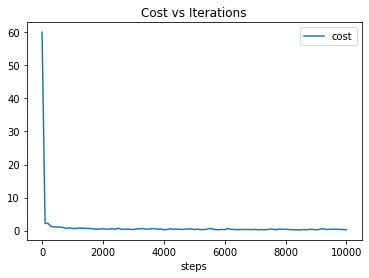

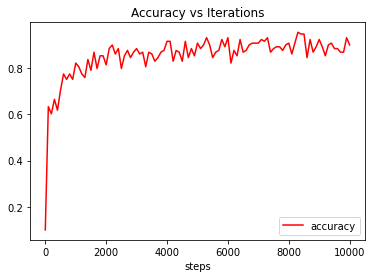

================ Experiment1 completed ==============

Experiment 2: For alpha = 5 -- 15 neuron

Cost at 0 iteration and accuracy are: 2.302316665649414 , 0.1640625

Cost at 1000 iteration and accuracy are: 0.32557088136672974 , 0.8984375

Cost at 2000 iteration and accuracy are: 0.27283990383148193 , 0.8984375

Cost at 3000 iteration and accuracy are: 0.28311687707901 , 0.921875

Cost at 4000 iteration and accuracy are: 0.1686275601387024 , 0.9609375

Cost at 5000 iteration and accuracy are: 0.13057172298431396 , 0.96875

Cost at 6000 iteration and accuracy are: 0.12451332807540894 , 0.9609375

Cost at 7000 iteration and accuracy are: 0.15569671988487244 , 0.9765625

Cost at 8000 iteration and accuracy are: 0.1656707525253296 , 0.9375

Cost at 9000 iteration and accuracy are: 0.1776159256696701 , 0.96875

Cost at 10000 iteration and accuracy are: 0.129031240940094 , 0.9609375
Accuracy of Train set: 0.96103334
Accuracy of Test set: 0.9525


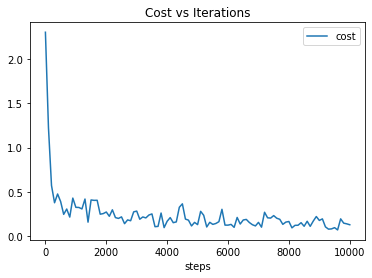

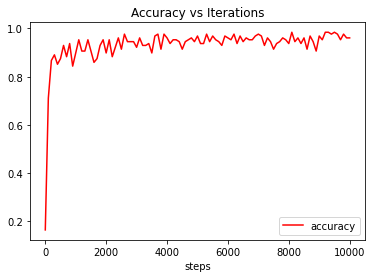

================ Experiment 2 completed ==============

Experiment 3: 70 neurons 1 hidden layer

Cost at 0 iteration and accuracy are: 2.301074981689453 , 0.1171875

Cost at 1000 iteration and accuracy are: 0.3741888403892517 , 0.921875

Cost at 2000 iteration and accuracy are: 0.19807030260562897 , 0.9609375

Cost at 3000 iteration and accuracy are: 0.1737336963415146 , 0.9453125

Cost at 4000 iteration and accuracy are: 0.1348605453968048 , 0.9609375

Cost at 5000 iteration and accuracy are: 0.1509186029434204 , 0.953125

Cost at 6000 iteration and accuracy are: 0.05147383362054825 , 0.9921875

Cost at 7000 iteration and accuracy are: 0.10982240736484528 , 0.984375

Cost at 8000 iteration and accuracy are: 0.08211559057235718 , 0.9765625

Cost at 9000 iteration and accuracy are: 0.07701677829027176 , 0.984375

Cost at 10000 iteration and accuracy are: 0.04868565499782562 , 0.9765625
Accuracy of Train set: 0.98338336
Accuracy of Test set: 0.9729


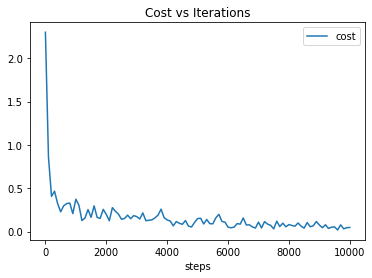

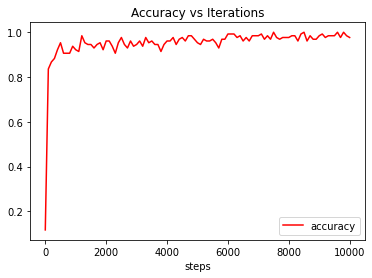

================ Experiment 3 completed ==============

Experiment 4: 150 neurons - 2 hidden layer

Cost at 0 iteration and accuracy are: 2.3023433685302734 , 0.1171875

Cost at 1000 iteration and accuracy are: 0.38683727383613586 , 0.890625

Cost at 2000 iteration and accuracy are: 0.212227925658226 , 0.9296875

Cost at 3000 iteration and accuracy are: 0.05641496181488037 , 0.984375

Cost at 4000 iteration and accuracy are: 0.17685258388519287 , 0.953125

Cost at 5000 iteration and accuracy are: 0.06489881873130798 , 0.984375

Cost at 6000 iteration and accuracy are: 0.052492186427116394 , 0.984375

Cost at 7000 iteration and accuracy are: 0.052558429539203644 , 0.984375

Cost at 8000 iteration and accuracy are: 0.044816430658102036 , 0.984375

Cost at 9000 iteration and accuracy are: 0.044648781418800354 , 0.984375

Cost at 10000 iteration and accuracy are: 0.03099244087934494 , 0.9921875
Accuracy of Train set: 0.99443334
Accuracy of Test set: 0.975


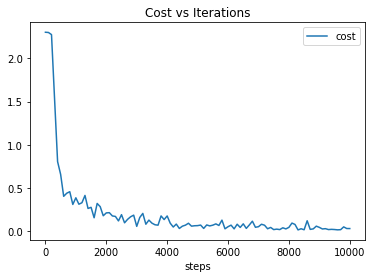

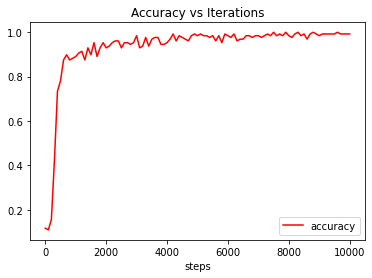

================ Experiment 4 completed ==============

Experiment 5: 200 neurons - 3 hidden layer

Cost at 0 iteration and accuracy are: 2.3027265071868896 , 0.1171875

Cost at 1000 iteration and accuracy are: 2.290022373199463 , 0.171875

Cost at 2000 iteration and accuracy are: 0.8956742286682129 , 0.6328125

Cost at 3000 iteration and accuracy are: 0.22577162086963654 , 0.921875

Cost at 4000 iteration and accuracy are: 0.12277869135141373 , 0.9765625

Cost at 5000 iteration and accuracy are: 0.11208522319793701 , 0.96875

Cost at 6000 iteration and accuracy are: 0.12434172630310059 , 0.9609375

Cost at 7000 iteration and accuracy are: 0.08794848620891571 , 0.9609375

Cost at 8000 iteration and accuracy are: 0.03695512190461159 , 0.9921875

Cost at 9000 iteration and accuracy are: 0.06636074185371399 , 0.984375

Cost at 10000 iteration and accuracy are: 0.01648954674601555 , 1.0
Accuracy of Train set: 0.9943333
Accuracy of Test set: 0.9696


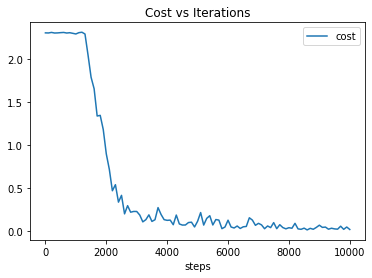

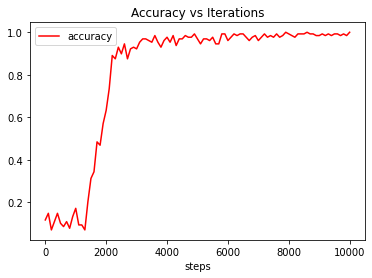

================ Experiment 5 completed ==============

Experiment 6: num of neurons = 2/3 hidden layer => 525 neurons ==> [784, 350, 150, 90, 35, 10]

Cost at 0 iteration and accuracy are: 2.302341938018799 , 0.09375

Cost at 1000 iteration and accuracy are: 2.29616379737854 , 0.171875

Cost at 2000 iteration and accuracy are: 2.298412799835205 , 0.125

Cost at 3000 iteration and accuracy are: 2.303462505340576 , 0.1015625

Cost at 4000 iteration and accuracy are: 1.2696419954299927 , 0.515625

Cost at 5000 iteration and accuracy are: 0.31502124667167664 , 0.9375

Cost at 6000 iteration and accuracy are: 0.12939798831939697 , 0.96875

Cost at 7000 iteration and accuracy are: 0.0441923551261425 , 0.9921875

Cost at 8000 iteration and accuracy are: 0.017091868445277214 , 0.9921875

Cost at 9000 iteration and accuracy are: 0.019410066306591034 , 0.9921875

Cost at 10000 iteration and accuracy are: 0.03449919819831848 , 0.984375
Accuracy of Train set: 0.9910167
Accuracy of Test set: 0.966

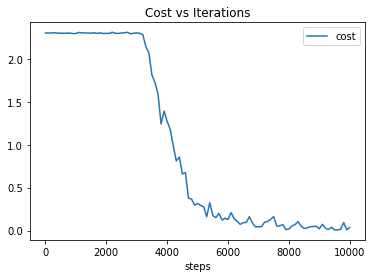

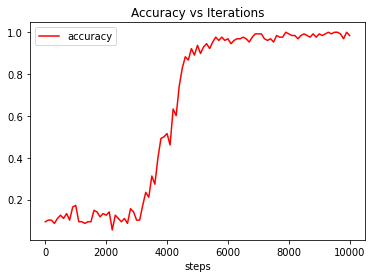

================ Experiment 6 completed ==============

Experiment 7: check what happens if we break thumb rule of num of hidden units < 2 * num of input units ==> hidden units = 1600 neurons ==> [784, 1000, 400, 100, 75, 25, 10]

Cost at 0 iteration and accuracy are: 2.303427219390869 , 0.0859375

Cost at 1000 iteration and accuracy are: 2.299241542816162 , 0.109375

Cost at 2000 iteration and accuracy are: 2.302593946456909 , 0.078125

Cost at 3000 iteration and accuracy are: 2.3045401573181152 , 0.1171875

Cost at 4000 iteration and accuracy are: 2.298436403274536 , 0.1015625

Cost at 5000 iteration and accuracy are: 2.3008081912994385 , 0.109375

Cost at 6000 iteration and accuracy are: 2.2988717555999756 , 0.109375

Cost at 7000 iteration and accuracy are: 2.2967114448547363 , 0.109375

Cost at 8000 iteration and accuracy are: 2.300142288208008 , 0.125

Cost at 9000 iteration and accuracy are: 2.301593780517578 , 0.1015625

Cost at 10000 iteration and accuracy are: 2.3030219078063

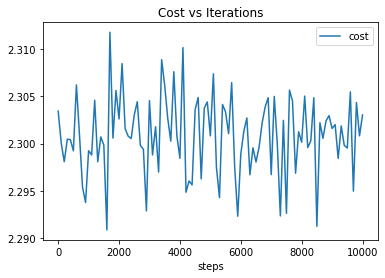

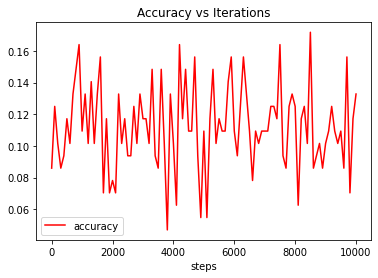

================ Experiment 7 completed ==============



In [0]:
run_hidden_layers_experiments()

Results of above experiments
1. Exp 1: for alfa = 2, 38 neurons. It seems there is an underfit and cost has't decreased even after 10000 iterations.

2. Exp 2: alfa = 5: 15 neurons. Surprisingly, this architecture performed significantly better than one of exp 1 and had reasoable good fit with test error = 95.25

3. Exp 3: 70 neuron 1 hidden layer. Surpringly this network config also did well and much better than exp 1 and 2 even though num of neurons 70 > 38(one in exp 1). Maybe 38 is a bad number.

4. Exp 4: this was the best architecture config given other params are constant with test accuracy of 97.5 % and one of the lowest cost of 0.03. But it seems like there might be a bit of an over fit as train error was 99.8. Maybe number of iterations should be reduced or learning rate must be tuned next for this architecture

5. Exp 5: [784, 100, 50, 10] - was more overfit than of exp 4

6. Exp 6: num of neurons = 2/3 hidden layer => 525 neurons ==> [784, 350, 150, 90, 35, 10] - again suffered from overfitting and much worse than exp 4

7. Exp 7: hidden neurons > 2 * input neurons - As expected, The thumb rule is right. the network performs much worse than the rest

**Experiments to check cost and accuracy plot by changing only learning rate  and keeping other hyperparameters constant**

In below network we fix on network architecture [784, 100, 50, 10] exp 4 and weight initialization and training iterations and use below experiments to check affect of learning rate on final outcome.
1. learning rate = 0.5
2. learning rate = 0.2
3. learning rate = 0.12
4. learning rate = 0.1
5. learning rate = 0.07

In [0]:
def run_learningrate_experiments():

  # exp1: lr = 0.5
  print("Experiment1: lr = 0.5")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.5, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment1 completed ==============")
  print("")

  # exp2: lr = 0.2
  print("Experiment1: lr = 0.2")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment1 completed ==============")
  print("")

  # exp3: lr = 0.12
  print("Experiment1: lr = 0.12")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.12, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment3 completed ==============")
  print("")

  # exp4: lr = 0.1
  print("Experiment1: lr = 0.1")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.1, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment4 completed ==============")
  print("")

  # exp5: lr = 0.07
  print("Experiment1: lr = 0.07")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.07, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment5 completed ==============")
  print("")

  return


Experiment1: lr = 0.5

Cost at 0 iteration and accuracy are: 2.302154779434204 , 0.09375

Cost at 1000 iteration and accuracy are: 0.1278582066297531 , 0.9609375

Cost at 2000 iteration and accuracy are: 0.030778057873249054 , 0.9921875

Cost at 3000 iteration and accuracy are: 0.023597899824380875 , 0.9921875

Cost at 4000 iteration and accuracy are: 0.030365390703082085 , 0.9921875

Cost at 5000 iteration and accuracy are: 0.06067007780075073 , 0.9765625

Cost at 6000 iteration and accuracy are: 0.018145915120840073 , 1.0

Cost at 7000 iteration and accuracy are: 0.013344762846827507 , 1.0

Cost at 8000 iteration and accuracy are: 0.03357917442917824 , 0.984375

Cost at 9000 iteration and accuracy are: 0.0038975891657173634 , 1.0

Cost at 10000 iteration and accuracy are: 0.003776774276047945 , 1.0
Accuracy of Train set: 0.99831665
Accuracy of Test set: 0.9773


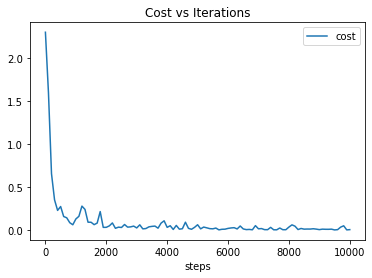

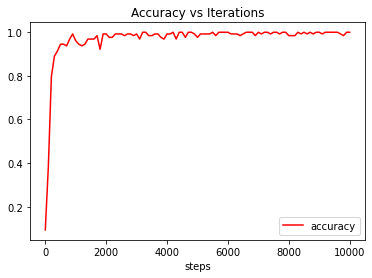

================ Experiment1 completed ==============

Experiment1: lr = 0.2

Cost at 0 iteration and accuracy are: 2.3023955821990967 , 0.1015625

Cost at 1000 iteration and accuracy are: 0.25807130336761475 , 0.9296875

Cost at 2000 iteration and accuracy are: 0.08724793791770935 , 0.9765625

Cost at 3000 iteration and accuracy are: 0.04503411054611206 , 0.9921875

Cost at 4000 iteration and accuracy are: 0.030002551153302193 , 0.984375

Cost at 5000 iteration and accuracy are: 0.012312035076320171 , 1.0

Cost at 6000 iteration and accuracy are: 0.008791472762823105 , 1.0

Cost at 7000 iteration and accuracy are: 0.01616322249174118 , 0.9921875

Cost at 8000 iteration and accuracy are: 0.01326808612793684 , 1.0

Cost at 9000 iteration and accuracy are: 0.007200503721833229 , 1.0

Cost at 10000 iteration and accuracy are: 0.0035076013300567865 , 1.0
Accuracy of Train set: 0.99913335
Accuracy of Test set: 0.978


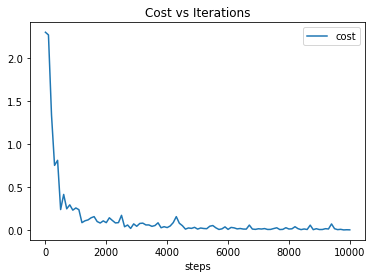

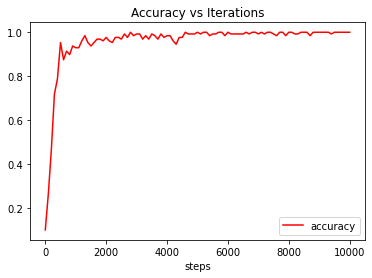

================ Experiment1 completed ==============

Experiment1: lr = 0.12

Cost at 0 iteration and accuracy are: 2.3026444911956787 , 0.0859375

Cost at 1000 iteration and accuracy are: 0.32495492696762085 , 0.90625

Cost at 2000 iteration and accuracy are: 0.21492630243301392 , 0.9453125

Cost at 3000 iteration and accuracy are: 0.15123000741004944 , 0.9609375

Cost at 4000 iteration and accuracy are: 0.1042584478855133 , 0.96875

Cost at 5000 iteration and accuracy are: 0.04328441619873047 , 0.9921875

Cost at 6000 iteration and accuracy are: 0.02565036341547966 , 1.0

Cost at 7000 iteration and accuracy are: 0.04498538374900818 , 0.9765625

Cost at 8000 iteration and accuracy are: 0.013279137201607227 , 1.0

Cost at 9000 iteration and accuracy are: 0.057758137583732605 , 0.96875

Cost at 10000 iteration and accuracy are: 0.01829918473958969 , 1.0
Accuracy of Train set: 0.9958
Accuracy of Test set: 0.9759


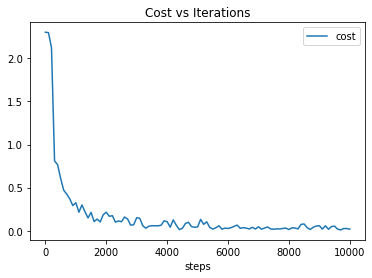

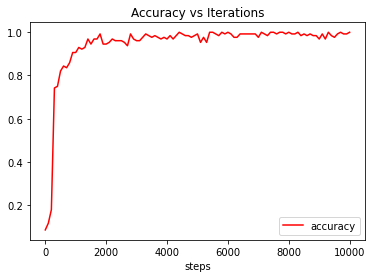

================ Experiment3 completed ==============

Experiment1: lr = 0.1

Cost at 0 iteration and accuracy are: 2.302656650543213 , 0.1015625

Cost at 1000 iteration and accuracy are: 0.32636162638664246 , 0.9140625

Cost at 2000 iteration and accuracy are: 0.1834227442741394 , 0.9453125

Cost at 3000 iteration and accuracy are: 0.08532816916704178 , 0.9765625

Cost at 4000 iteration and accuracy are: 0.022222381085157394 , 1.0

Cost at 5000 iteration and accuracy are: 0.05009865760803223 , 0.984375

Cost at 6000 iteration and accuracy are: 0.09532826393842697 , 0.984375

Cost at 7000 iteration and accuracy are: 0.07468970119953156 , 0.9765625

Cost at 8000 iteration and accuracy are: 0.034578148275613785 , 0.984375

Cost at 9000 iteration and accuracy are: 0.012478183954954147 , 1.0

Cost at 10000 iteration and accuracy are: 0.04571354389190674 , 0.984375
Accuracy of Train set: 0.99325
Accuracy of Test set: 0.9759


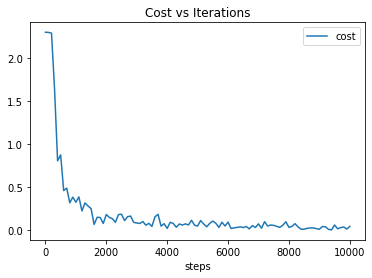

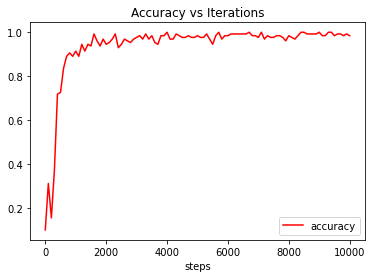

================ Experiment4 completed ==============

Experiment1: lr = 0.07

Cost at 0 iteration and accuracy are: 2.3016107082366943 , 0.1171875

Cost at 1000 iteration and accuracy are: 0.5224173069000244 , 0.828125

Cost at 2000 iteration and accuracy are: 0.32173964381217957 , 0.8984375

Cost at 3000 iteration and accuracy are: 0.12496231496334076 , 0.9375

Cost at 4000 iteration and accuracy are: 0.08588212728500366 , 0.96875

Cost at 5000 iteration and accuracy are: 0.07605411857366562 , 0.9765625

Cost at 6000 iteration and accuracy are: 0.0997200682759285 , 0.9765625

Cost at 7000 iteration and accuracy are: 0.08758050203323364 , 0.96875

Cost at 8000 iteration and accuracy are: 0.06757034361362457 , 0.984375

Cost at 9000 iteration and accuracy are: 0.0888184905052185 , 0.9765625

Cost at 10000 iteration and accuracy are: 0.01739003323018551 , 1.0
Accuracy of Train set: 0.9898833
Accuracy of Test set: 0.9764


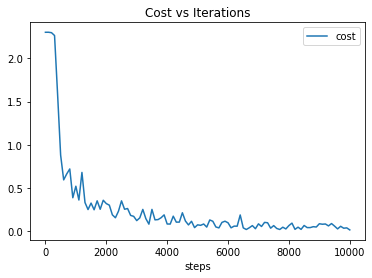

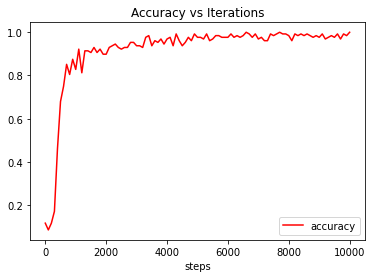

================ Experiment5 completed ==============



In [0]:
run_learningrate_experiments()

Results of learning rate experiment

As we can see from above 5 experiments learning rates of 0.2 and 0.12 tends to be much better than others.
Although exp5 test accuracy is much more than that of exp1 its train accuracy is < 0.99, it may slightly underfit. Hence choose learning rate as 0.2 or 0.12 in next experiments

**Experiments to check cost and accuracy plot by changing only weight initialization and keeping other hyperparameters constant**

In below network we fix on other parameter and use below experiments to check affect of parameter initialization on final outcome.

1. param_initializer = 1
2. param_initializer = 0.1
3. param_initializer = 0.01
4. param_initializer = 0.001

In [0]:
def run_initialization_experiments():

  # exp1: pi = 1
  print("Experiment1: param_initializer pi = 1")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 1)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment1 completed ==============")
  print("")

  # exp2: pi = 0.1
  print("Experiment1: pi = 0.1")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.1)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment2 completed ==============")
  print("")

  # exp3:  pi = 0.01
  print("Experiment1: pi = 0.01")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment3 completed ==============")
  print("")

  # exp4: lr =  pi = 0.001
  print("Experiment1: lr = 0.001")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.001)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment4 completed ==============")
  print("")

  return

Experiment1: param_initializer pi = 1

Cost at 0 iteration and accuracy are: 865.2145385742188 , 0.0729166641831398

Cost at 1000 iteration and accuracy are: 2.3025853633880615 , 0.0859375

Cost at 2000 iteration and accuracy are: 2.3025853633880615 , 0.1015625

Cost at 3000 iteration and accuracy are: 2.3025853633880615 , 0.0859375

Cost at 4000 iteration and accuracy are: 2.3025853633880615 , 0.0859375

Cost at 5000 iteration and accuracy are: 2.3025853633880615 , 0.09375

Cost at 6000 iteration and accuracy are: 2.3025853633880615 , 0.109375

Cost at 7000 iteration and accuracy are: 2.3025853633880615 , 0.0859375

Cost at 8000 iteration and accuracy are: 2.3025853633880615 , 0.0546875

Cost at 9000 iteration and accuracy are: 2.3025853633880615 , 0.078125

Cost at 10000 iteration and accuracy are: 2.3025853633880615 , 0.1015625
Accuracy of Train set: 0.09871667
Accuracy of Test set: 0.098


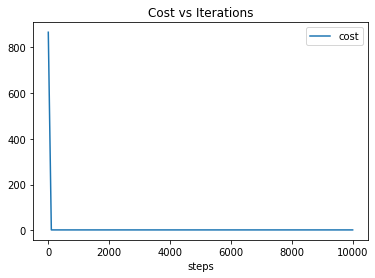

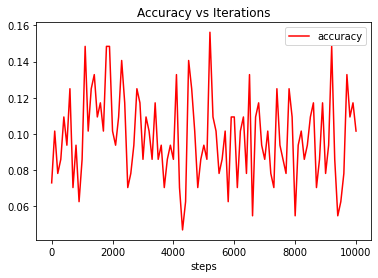

================ Experiment1 completed ==============

Experiment1: pi = 0.1

Cost at 0 iteration and accuracy are: 2.864741802215576 , 0.09375

Cost at 1000 iteration and accuracy are: 0.1594911813735962 , 0.9453125

Cost at 2000 iteration and accuracy are: 0.09221991896629333 , 0.9765625

Cost at 3000 iteration and accuracy are: 0.09793485701084137 , 0.96875

Cost at 4000 iteration and accuracy are: 0.018469136208295822 , 0.9921875

Cost at 5000 iteration and accuracy are: 0.006853501312434673 , 1.0

Cost at 6000 iteration and accuracy are: 0.011426588520407677 , 1.0

Cost at 7000 iteration and accuracy are: 0.021259361878037453 , 0.9921875

Cost at 8000 iteration and accuracy are: 0.000984922400675714 , 1.0

Cost at 9000 iteration and accuracy are: 0.016508832573890686 , 1.0

Cost at 10000 iteration and accuracy are: 0.007508823182433844 , 1.0
Accuracy of Train set: 0.99918336
Accuracy of Test set: 0.9761


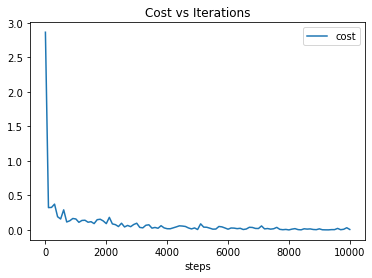

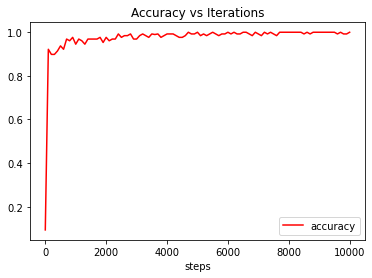

================ Experiment2 completed ==============

Experiment1: pi = 0.01

Cost at 0 iteration and accuracy are: 2.3034253120422363 , 0.0859375

Cost at 1000 iteration and accuracy are: 0.17732593417167664 , 0.953125

Cost at 2000 iteration and accuracy are: 0.07931490242481232 , 0.984375

Cost at 3000 iteration and accuracy are: 0.07592421025037766 , 0.96875

Cost at 4000 iteration and accuracy are: 0.03487507998943329 , 0.9921875

Cost at 5000 iteration and accuracy are: 0.004850605968385935 , 1.0

Cost at 6000 iteration and accuracy are: 0.04187023639678955 , 0.9921875

Cost at 7000 iteration and accuracy are: 0.017606597393751144 , 0.9921875

Cost at 8000 iteration and accuracy are: 0.00792866013944149 , 1.0

Cost at 9000 iteration and accuracy are: 0.017348282039165497 , 0.9921875

Cost at 10000 iteration and accuracy are: 0.007722364738583565 , 1.0
Accuracy of Train set: 0.99945
Accuracy of Test set: 0.9796


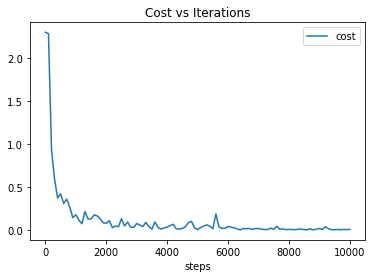

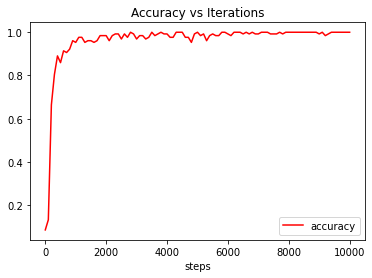

================ Experiment3 completed ==============

Experiment1: lr = 0.001

Cost at 0 iteration and accuracy are: 2.302586317062378 , 0.09375

Cost at 1000 iteration and accuracy are: 1.4288394451141357 , 0.421875

Cost at 2000 iteration and accuracy are: 0.384046733379364 , 0.875

Cost at 3000 iteration and accuracy are: 0.17551353573799133 , 0.953125

Cost at 4000 iteration and accuracy are: 0.09287766367197037 , 0.96875

Cost at 5000 iteration and accuracy are: 0.0980948656797409 , 0.9765625

Cost at 6000 iteration and accuracy are: 0.10874180495738983 , 0.984375

Cost at 7000 iteration and accuracy are: 0.012522169388830662 , 1.0

Cost at 8000 iteration and accuracy are: 0.014729084447026253 , 1.0

Cost at 9000 iteration and accuracy are: 0.021559683606028557 , 0.9921875

Cost at 10000 iteration and accuracy are: 0.016371851786971092 , 0.9921875
Accuracy of Train set: 0.99488336
Accuracy of Test set: 0.976


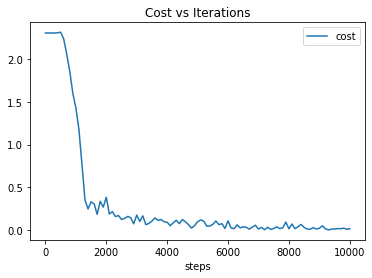

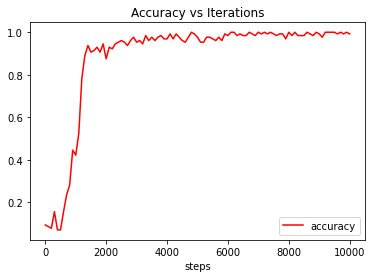

================ Experiment4 completed ==============



In [0]:
run_initialization_experiments()

**Results of initialization experiment**

Param initialization of 0.01 clearly beats others (1, 0.1 and 0.01). Starting too far or too near to zero might either slowdown(pi = 0.1 and 0.01) or completely stop learning(pi = 1)

**Experiments to check cost and accuracy plot by changing only iterations and keeping other hyperparameters constant**

In below network we fix onother hyper params and use below experiments to check affect of iterations on final outcome.
1. iterations = 5000
2. iterations = 8000
3. iterations = 9000
4. iterations = 10000
5. iterations = 11000

In [0]:
def run_iterations_experiments():

  # exp1: itr = 5000
  print("Experiment1: itr = 5000")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 5000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment1 completed ==============")
  print("")

  # exp2: itr = 8000
  print("Experiment1: itr = 8000")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 8000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment2 completed ==============")
  print("")

  # exp3:  itr = 9000
  print("Experiment1: itr = 9000")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 9000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment3 completed ==============")
  print("")

  # exp4: itr = 10000
  print("Experiment1: litr = 10000")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment4 completed ==============")
  print("")

  # exp4: itr = 11000
  print("Experiment1: litr = 11000")
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 11000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment4 completed ==============")
  print("")
  
  return

Experiment1: itr = 5000

Cost at 0 iteration and accuracy are: 2.3023159503936768 , 0.078125

Cost at 1000 iteration and accuracy are: 0.18342503905296326 , 0.9609375

Cost at 2000 iteration and accuracy are: 0.0716177448630333 , 0.984375

Cost at 3000 iteration and accuracy are: 0.08863361179828644 , 0.9765625

Cost at 4000 iteration and accuracy are: 0.03525678440928459 , 0.9921875

Cost at 5000 iteration and accuracy are: 0.015383323654532433 , 1.0
Accuracy of Train set: 0.9932167
Accuracy of Test set: 0.9757


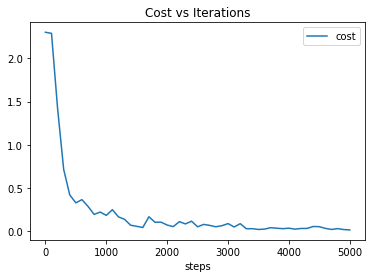

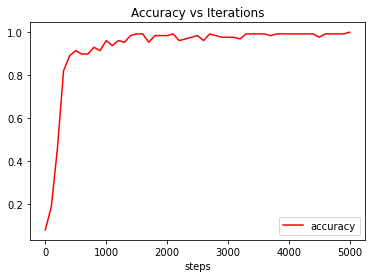

================ Experiment1 completed ==============

Experiment1: itr = 8000

Cost at 0 iteration and accuracy are: 2.3022289276123047 , 0.125

Cost at 1000 iteration and accuracy are: 0.1714375615119934 , 0.9375

Cost at 2000 iteration and accuracy are: 0.04705675691366196 , 0.9765625

Cost at 3000 iteration and accuracy are: 0.06904303282499313 , 0.96875

Cost at 4000 iteration and accuracy are: 0.025566818192601204 , 0.984375

Cost at 5000 iteration and accuracy are: 0.10189377516508102 , 0.953125

Cost at 6000 iteration and accuracy are: 0.03499211370944977 , 0.9921875

Cost at 7000 iteration and accuracy are: 0.014030877500772476 , 1.0

Cost at 8000 iteration and accuracy are: 0.011934487149119377 , 0.9921875
Accuracy of Train set: 0.9974333
Accuracy of Test set: 0.978


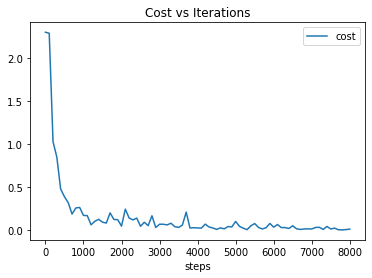

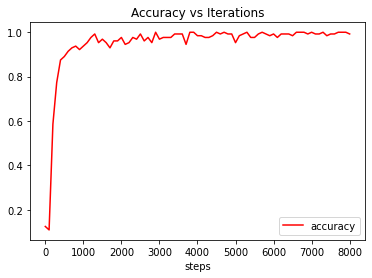

================ Experiment2 completed ==============

Experiment1: itr = 9000

Cost at 0 iteration and accuracy are: 2.3025012016296387 , 0.1171875

Cost at 1000 iteration and accuracy are: 0.17411813139915466 , 0.9375

Cost at 2000 iteration and accuracy are: 0.07257238775491714 , 0.9765625

Cost at 3000 iteration and accuracy are: 0.09256678819656372 , 0.96875

Cost at 4000 iteration and accuracy are: 0.020365256816148758 , 1.0

Cost at 5000 iteration and accuracy are: 0.014413965865969658 , 1.0

Cost at 6000 iteration and accuracy are: 0.030676573514938354 , 0.984375

Cost at 7000 iteration and accuracy are: 0.030998893082141876 , 0.984375

Cost at 8000 iteration and accuracy are: 0.007354778237640858 , 1.0

Cost at 9000 iteration and accuracy are: 0.016609929502010345 , 1.0
Accuracy of Train set: 0.99885
Accuracy of Test set: 0.9775


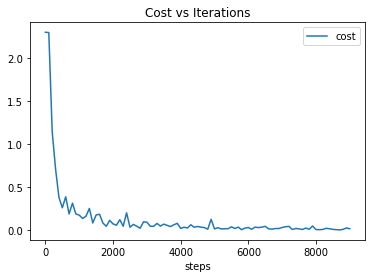

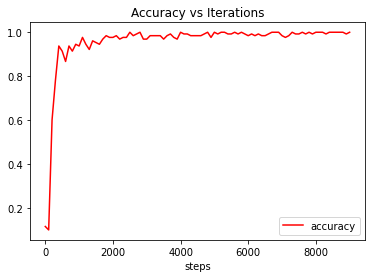

================ Experiment3 completed ==============

Experiment1: litr = 10000

Cost at 0 iteration and accuracy are: 2.3007476329803467 , 0.1484375

Cost at 1000 iteration and accuracy are: 0.2468509078025818 , 0.953125

Cost at 2000 iteration and accuracy are: 0.058769792318344116 , 0.984375

Cost at 3000 iteration and accuracy are: 0.09017659723758698 , 0.96875

Cost at 4000 iteration and accuracy are: 0.034653425216674805 , 0.9921875

Cost at 5000 iteration and accuracy are: 0.09451785683631897 , 0.9609375

Cost at 6000 iteration and accuracy are: 0.005789896473288536 , 1.0

Cost at 7000 iteration and accuracy are: 0.022201374173164368 , 0.984375

Cost at 8000 iteration and accuracy are: 0.010155580006539822 , 0.9921875

Cost at 9000 iteration and accuracy are: 0.012918058782815933 , 1.0

Cost at 10000 iteration and accuracy are: 0.001635266002267599 , 1.0
Accuracy of Train set: 0.99938333
Accuracy of Test set: 0.9783


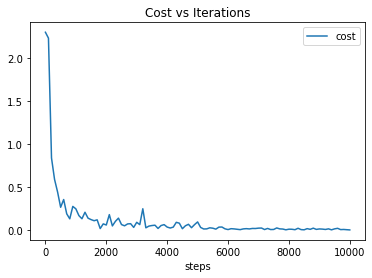

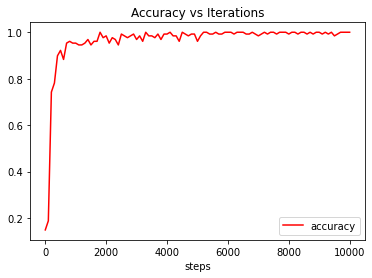

================ Experiment4 completed ==============

Experiment1: litr = 11000

Cost at 0 iteration and accuracy are: 2.3010575771331787 , 0.078125

Cost at 1000 iteration and accuracy are: 0.1778540164232254 , 0.953125

Cost at 2000 iteration and accuracy are: 0.14023037254810333 , 0.953125

Cost at 3000 iteration and accuracy are: 0.03920673578977585 , 0.984375

Cost at 4000 iteration and accuracy are: 0.0600239634513855 , 0.984375

Cost at 5000 iteration and accuracy are: 0.037943899631500244 , 0.9921875

Cost at 6000 iteration and accuracy are: 0.020338913425803185 , 0.9921875

Cost at 7000 iteration and accuracy are: 0.022418571636080742 , 1.0

Cost at 8000 iteration and accuracy are: 0.003245549276471138 , 1.0

Cost at 9000 iteration and accuracy are: 0.03000875748693943 , 0.984375

Cost at 10000 iteration and accuracy are: 0.0020652026869356632 , 1.0

Cost at 11000 iteration and accuracy are: 0.0039380332455039024 , 1.0
Accuracy of Train set: 0.99945
Accuracy of Test set: 0.97

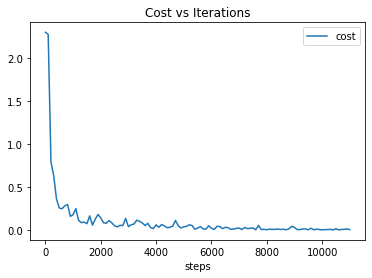

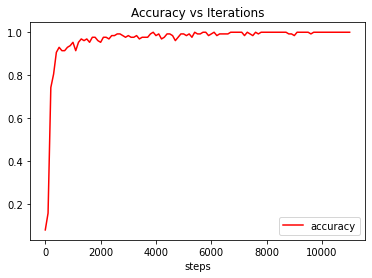

================ Experiment4 completed ==============



In [0]:
run_iterations_experiments()

**Results of the iterations experiment**

As we can see even all the iteration from 5000 - 11000 are giving reasonable values. But we can stick with existing 10k iterations

**Experiment to check the impact of batch size on final outcome**

In below network we fix onother hyper params and use below experiments to check affect of iterations on final outcome.
1. batch size = 64
2. batch size = 128
3. batch size = 256
4. batch size = 32


In [0]:
def run_batch_size_experiments():

  # exp1: batch size = 64
  print("Experiment1: batch size = 64")
  data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=64)
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.2, batch_size = 64)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment1 completed ==============")
  print("")

  # exp2: batch size = 128
  print("Experiment2: batch size = 128")
  data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.2, batch_size = 128)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment2 completed ==============")
  print("")

  # exp3:  batch size = 256
  print("Experiment3: batch size = 256")
  data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=256)
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.2, batch_size = 256)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment3 completed ==============")
  print("")

  # exp4:  batch size = 32
  print("Experiment4: batch size = 32")
  data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=32)
  layer_matrix =  [784, 100, 50, 10] 
  hyper_parameters = init_hyperparameters(iterations = 10000, learning_rate = 0.2, batch_size = 32)
  params, params_list = init_params(layer_matrix = layer_matrix, param_initializer = 0.01)
  activations = init_activations(layer_matrix= layer_matrix)

  costs, report_dict = run_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  dummy = get_training_accuracy_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  predicted_labels = test_model(hyper_parameters, params, activations,  params_list, activation_function="relu")
  plot_figures(hyper_parameters, report_dict)
  print("================ Experiment4 completed ==============")
  print("")

  return

Experiment1: batch size = 64

Cost at 0 iteration and accuracy are: 2.3024115562438965 , 0.15625

Cost at 1000 iteration and accuracy are: 0.2341773509979248 , 0.9453125

Cost at 2000 iteration and accuracy are: 0.08794564008712769 , 0.9765625

Cost at 3000 iteration and accuracy are: 0.05938291549682617 , 0.9765625

Cost at 4000 iteration and accuracy are: 0.07425212860107422 , 0.96875

Cost at 5000 iteration and accuracy are: 0.020084332674741745 , 1.0

Cost at 6000 iteration and accuracy are: 0.010139362886548042 , 1.0

Cost at 7000 iteration and accuracy are: 0.015441179275512695 , 0.9921875

Cost at 8000 iteration and accuracy are: 0.004617263562977314 , 1.0

Cost at 9000 iteration and accuracy are: 0.010924429632723331 , 1.0

Cost at 10000 iteration and accuracy are: 0.0016614707419648767 , 1.0
Accuracy of Train set: 0.9993167
Accuracy of Test set: 0.9776


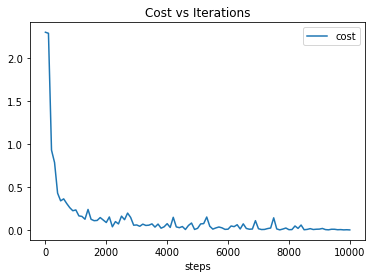

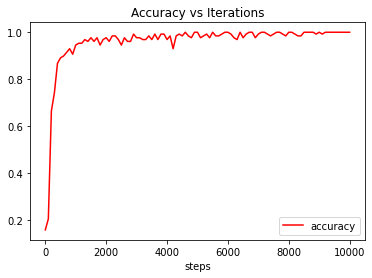

================ Experiment1 completed ==============

Experiment2: batch size = 128

Cost at 0 iteration and accuracy are: 2.302576780319214 , 0.0859375

Cost at 1000 iteration and accuracy are: 0.16630885004997253 , 0.953125

Cost at 2000 iteration and accuracy are: 0.08686120063066483 , 0.96875

Cost at 3000 iteration and accuracy are: 0.08002278208732605 , 0.984375

Cost at 4000 iteration and accuracy are: 0.048253461718559265 , 0.984375

Cost at 5000 iteration and accuracy are: 0.034750115126371384 , 0.984375

Cost at 6000 iteration and accuracy are: 0.012334558181464672 , 1.0

Cost at 7000 iteration and accuracy are: 0.013058165088295937 , 1.0

Cost at 8000 iteration and accuracy are: 0.006805872544646263 , 1.0

Cost at 9000 iteration and accuracy are: 0.0033941068686544895 , 1.0

Cost at 10000 iteration and accuracy are: 0.01797550357878208 , 0.9921875
Accuracy of Train set: 0.9989167
Accuracy of Test set: 0.9787


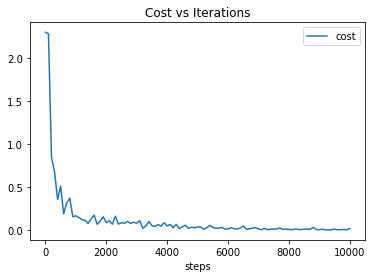

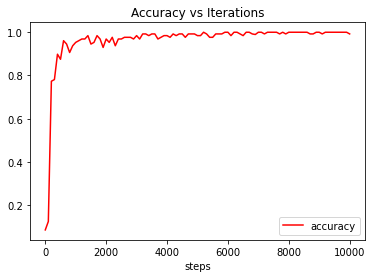

================ Experiment2 completed ==============

Experiment3: batch size = 256

Cost at 0 iteration and accuracy are: 2.3033864498138428 , 0.0546875

Cost at 1000 iteration and accuracy are: 0.21956214308738708 , 0.9296875

Cost at 2000 iteration and accuracy are: 0.0636514201760292 , 0.9921875

Cost at 3000 iteration and accuracy are: 0.05552532523870468 , 0.9765625

Cost at 4000 iteration and accuracy are: 0.02925923466682434 , 0.984375

Cost at 5000 iteration and accuracy are: 0.006830226629972458 , 1.0

Cost at 6000 iteration and accuracy are: 0.017059609293937683 , 1.0

Cost at 7000 iteration and accuracy are: 0.026305880397558212 , 0.9921875

Cost at 8000 iteration and accuracy are: 0.007707375101745129 , 1.0

Cost at 9000 iteration and accuracy are: 0.021156350150704384 , 0.9921875

Cost at 10000 iteration and accuracy are: 0.017977003008127213 , 0.9921875
Accuracy of Train set: 0.99875
Accuracy of Test set: 0.9791


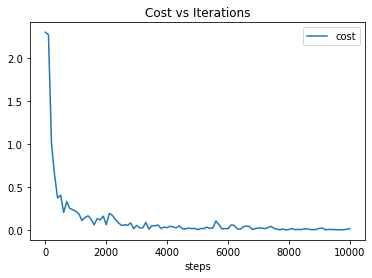

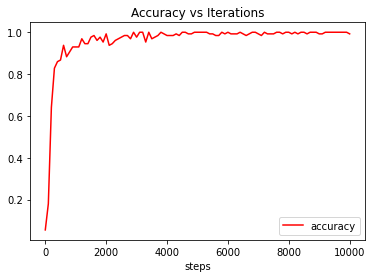

================ Experiment3 completed ==============

Experiment4: batch size = 32

Cost at 0 iteration and accuracy are: 2.3022191524505615 , 0.1171875

Cost at 1000 iteration and accuracy are: 0.15408733487129211 , 0.96875

Cost at 2000 iteration and accuracy are: 0.04378797858953476 , 0.9765625

Cost at 3000 iteration and accuracy are: 0.051477327942848206 , 0.984375

Cost at 4000 iteration and accuracy are: 0.04728400707244873 , 0.984375

Cost at 5000 iteration and accuracy are: 0.026174413040280342 , 1.0

Cost at 6000 iteration and accuracy are: 0.017115218564867973 , 0.9921875

Cost at 7000 iteration and accuracy are: 0.022123180329799652 , 0.9921875

Cost at 8000 iteration and accuracy are: 0.024934247136116028 , 0.9921875

Cost at 9000 iteration and accuracy are: 0.005797527730464935 , 1.0

Cost at 10000 iteration and accuracy are: 0.0045806122943758965 , 1.0
Accuracy of Train set: 0.9994
Accuracy of Test set: 0.9791


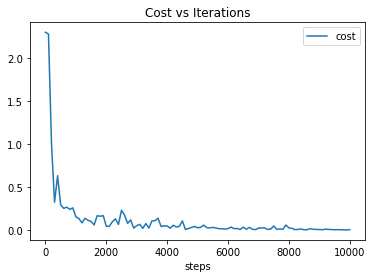

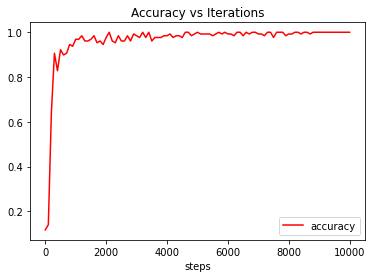

================ Experiment4 completed ==============



In [0]:
run_batch_size_experiments()

As we can see that batch size also has some affect and batch size of 32 and 256 seems to be giving a bit better results

In [0]:
"""
for step in range(5000):
  train_features_batch, train_labels_batch = data.next_batch()

  with tf.GradientTape() as tape:
    #tape.watch([W1, B1, W2, B2])
    Z1 = tf.matmul(train_features_batch, W1) + B1
    A1 = tf.nn.relu(Z1)
    #tape.watch([Z1, A1])
    logits = tf.matmul(A1, W2) + B2
    
    xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = train_labels_batch, logits = logits))
    #tape.watch(xent)
  
  grads = tape.gradient(xent, [ W1, B1, W2, B2])
  #print(grads[0] )
  #print(grads[1])
  #print(grads[2])
  W1.assign_sub(learning_rate * grads[0])
  B1.assign_sub(learning_rate * grads[1])
  W2.assign_sub(learning_rate * grads[2])
  B2.assign_sub(learning_rate * grads[3])


  if(step%500 == 0):
    # print(grads)
    #print(grads[0])
    #print(grads[1])
    #print(grads[2])
    #print(grads[3])
    preds = tf.argmax(logits, axis = 1,output_type = tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, train_labels_batch), dtype = tf.float32))
    print("Loss: {} and Accuracy: {}".format(xent, acc))
"""

'\nfor step in range(5000):\n  train_features_batch, train_labels_batch = data.next_batch()\n\n  with tf.GradientTape() as tape:\n    #tape.watch([W1, B1, W2, B2])\n    Z1 = tf.matmul(train_features_batch, W1) + B1\n    A1 = tf.nn.relu(Z1)\n    #tape.watch([Z1, A1])\n    logits = tf.matmul(A1, W2) + B2\n    \n    xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = train_labels_batch, logits = logits))\n    #tape.watch(xent)\n  \n  grads = tape.gradient(xent, [ W1, B1, W2, B2])\n  #print(grads[0] )\n  #print(grads[1])\n  #print(grads[2])\n  W1.assign_sub(learning_rate * grads[0])\n  B1.assign_sub(learning_rate * grads[1])\n  W2.assign_sub(learning_rate * grads[2])\n  B2.assign_sub(learning_rate * grads[3])\n\n\n  if(step%500 == 0):\n    # print(grads)\n    #print(grads[0])\n    #print(grads[1])\n    #print(grads[2])\n    #print(grads[3])\n    preds = tf.argmax(logits, axis = 1,output_type = tf.int32)\n    acc = tf.reduce_mean(tf.cast(tf.equal(preds, train_label

In [0]:

"""
Z1_test = tf.matmul(data.test_data, W1) + B1
A1_test = tf.nn.relu(Z1_test)
#tape.watch([Z1, A1])
logits_test = tf.matmul(A1_test, W2) + B2

test_preds = tf.argmax(logits_test, axis=1,output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)
"""

'\nZ1_test = tf.matmul(data.test_data, W1) + B1\nA1_test = tf.nn.relu(Z1_test)\n#tape.watch([Z1, A1])\nlogits_test = tf.matmul(A1_test, W2) + B2\n\ntest_preds = tf.argmax(logits_test, axis=1,output_type=tf.int32)\nacc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),\n                             tf.float32))\nprint(acc)\n'